In [ ]:
# https://www.youtube.com/watch?v=ZMudJXhsUpY&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=6

# Instalación de librerías e imports

In [4]:
import numpy as np
from google.colab import drive
import re

from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.layers import Input, Concatenate, Dot, RepeatVector, TimeDistributed, Multiply
from tensorflow.keras.layers import Bidirectional, LSTM, Activation, Reshape, Lambda, Dropout, GRU
from tensorflow.keras.utils import plot_model, to_categorical, pad_sequences
import tensorflow.keras.callbacks as callbacks


In [2]:
# Downloading fasttext word vectors
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
#!unzip wiki-news-300d-1M.vec.zip
#!ls

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


# Preparación de datasets

## División de txt en arreglo de párrafos

In [6]:
filepath= '/content/drive/My Drive/Dr. Jekyll and Mr. Hyde.txt'
#filepath= '/content/drive/My Drive/The Holy Bible.txt'

with open(filepath, 'r') as file:
    text = file.read()

parrafos = text.lower().split('\n\n') # Dividir el contenido en párrafos

# Eliminamos enters y espacios en blanco.
dataset = [parrafo.strip().replace('\n', ' ') for parrafo in parrafos if parrafo !=""]

In [7]:
dataset[15]

'“a very good rule, too,” said the lawyer.'

In [8]:
#print(dataset[1500])
#for i in range(len(dataset)):
#  if ':' in dataset[i][:7]:
#    dataset[i]= dataset[i].split('.')[1]

#dataset[1500]

In [9]:
corpus_size = len(dataset)
corpus_size

349

In [10]:
from sklearn.model_selection import train_test_split
trainset, testset, _, _= train_test_split(dataset, range(corpus_size), test_size=0.2, random_state=42, shuffle=True)

trainset[0]

'“sir,” said the butler, turning to a sort of mottled pallor, “that thing was not my master, and there’s the truth. my master”—here he looked round him and began to whisper—“is a tall, fine build of a man, and this was more of a dwarf.” utterson attempted to protest. “o, sir,” cried poole, “do you think i do not know my master after twenty years? do you think i do not know where his head comes to in the cabinet door, where i saw him every morning of my life? no, sir, that thing in the mask was never dr. jekyll—god knows what it was, but it was never dr. jekyll; and it is the belief of my heart that there was murder done.”'

## Tokenizacion de textos

In [11]:
from keras.preprocessing.text import Tokenizer

token=Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token="UNK", document_count=0)

token.fit_on_texts(trainset)

dictionary = token.index_word
vocab_size=len(dictionary)+1

In [12]:
vocab_size

3479

In [13]:
def genSequences(token, text_set, max_len=500):
  x_sequences = []
  y_sequences = []

  tokenized = token.texts_to_sequences(text_set)  # Tokenizo los textos

  # Armo secuencias de largo max_len o menor
  for text in tokenized:
    for i in range(1, len(text)):
      x_sequences.append(text[:i])  # Arreglos de entrada
      y_sequences.append(text[i])   # Arreglos de salida

  x_sequences = pad_sequences(x_sequences, maxlen=max_len, padding='pre', truncating='pre')
  y_sequences = to_categorical(y_sequences, num_classes=len(token.index_word)+1)

  return x_sequences, y_sequences

In [14]:
max_len=500

x_train, y_train = genSequences(token, trainset, max_len=max_len)
x_test, y_test = genSequences(token, testset, max_len=max_len)

In [15]:
print(token.sequences_to_texts([x_train[10][-15:]]))
x_train[10][-15:]

['UNK UNK UNK UNK “sir ” said the butler turning to a sort of mottled']


array([   0,    0,    0,    0,  651,    9,   24,    2,  282, 1437,    5,
          6,  434,    4, 1438], dtype=int32)

# Carga de embeddings (TP viejo)

In [ ]:
import codecs

embedding_dim=300               # Dato de FastText
embedding_matrix=np.zeros([vocab_size,embedding_dim])

embed_path='/content/drive/My Drive/wiki-news-300d-1M.vec'

#carga de embeddings externos
f = codecs.open(embed_path, encoding='utf-8')

for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')

    # Armamos la matriz de embeddings en base a nuestro vocab
    if word in token.index_word.values():
      idx = next((idx for idx, dict_word in token.index_word.items() if dict_word == word), None)
      if idx != None:
        embedding_matrix[idx,:] = coefs

f.close()

np.save('/content/drive/My Drive/Jekyllembeed.npy', embedding_matrix)

## Carga de matriz ya ordenada

In [16]:
embedding_dim=300               # Dato de FastText
embedding_matrix=np.zeros([vocab_size,embedding_dim])

embedding_matrix = np.load('/content/drive/My Drive/Jekyllembeed.npy')

In [17]:
print("Tamaño vocabulario: ", vocab_size)
print("Dim matriz de embeddings: ", embedding_matrix.shape)

Tamaño vocabulario:  3479
Dim matriz de embeddings:  (3479, 300)


# Modelo

## LSTM

### Arquitectura

In [18]:
def softMaxOverTime(x):
    return tf.keras.activations.softmax(x,axis=1)

In [26]:
LSTM_dim=100

input_layer = Input(shape=(max_len,))

embedding_layer=Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                          weights=[embedding_matrix], input_length=max_len,
                          trainable=False)(input_layer) # Embeddings pre entrenados

# Por que merge mode = sum?
lstm_out=Bidirectional(LSTM(LSTM_dim, return_sequences=True, activation="tanh"), merge_mode="sum")(embedding_layer)
ulog_attention=Dense(1,activation="linear")(lstm_out)

attention=Activation(softMaxOverTime)(ulog_attention)
repeated_attention=TimeDistributed(RepeatVector(LSTM_dim))(attention)
repeated_attention=Reshape([max_len,LSTM_dim])(repeated_attention)

weighted_embeddings=Multiply()([repeated_attention,lstm_out])
embedding_sum = Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(weighted_embeddings)

dense0=Dense(vocab_size//16, activation='relu')(embedding_sum)
dense1=Dense(vocab_size//4, activation='relu')(dense0)
dense2=Dense(vocab_size, activation='softmax')(dense1)

model=Model(input_layer , dense2)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 500, 300)             1043700   ['input_2[0][0]']             
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 500, 100)             320800    ['embedding_1[0][0]']         
 onal)                                                                                            
                                                                                                  
 dense_4 (Dense)             (None, 500, 1)               101       ['bidirectional_1[0][0]'

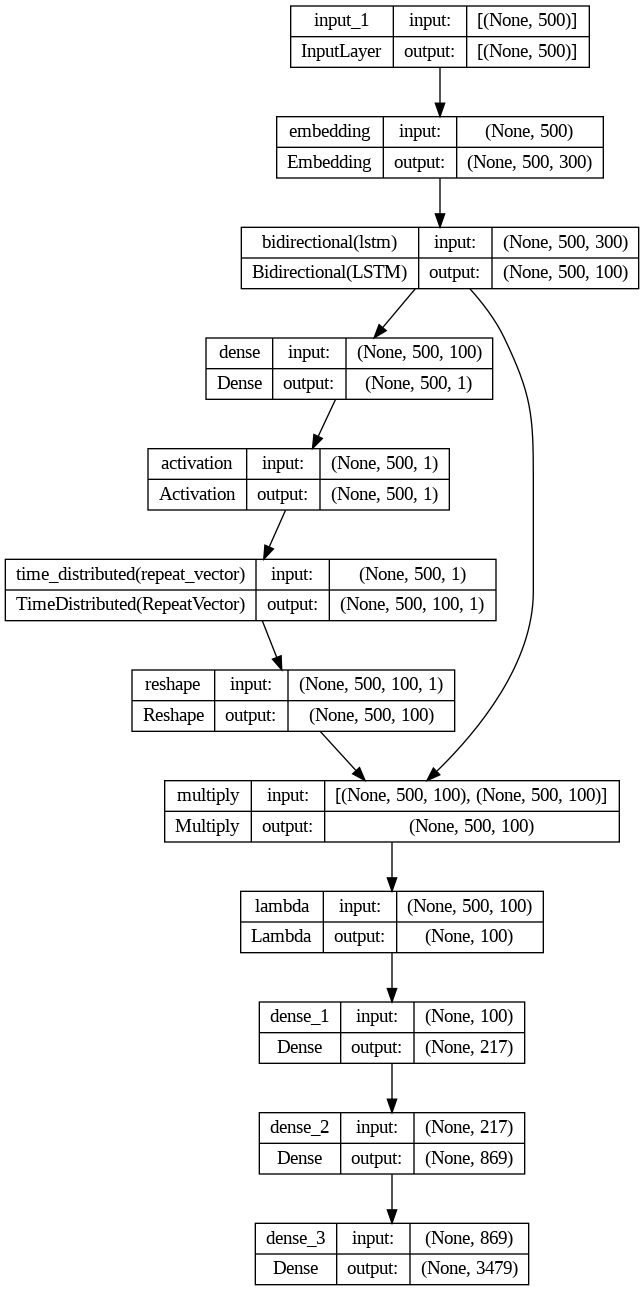

In [20]:
plot_model(model, "LM_LSTM.png", show_shapes=True)

In [29]:
#adam = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
adam = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### Entrenamiento

In [22]:
file = "/content/drive/MyDrive/Jekyll.h5"


BATCH_SIZE = 128
check_cb = callbacks.ModelCheckpoint(monitor="accuracy", filepath=file, verbose = 0, save_best_only = True)

early_cb = callbacks.EarlyStopping(monitor="accuracy", min_delta=1e-3, patience=10,
                                   start_from_epoch=10)

In [23]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=75,
                    validation_split=0.1, callbacks=[early_cb])

Epoch 1/75
274/274 [==============================] - 27s 60ms/step - loss: 6.5537 - accuracy: 0.0564 - val_loss: 6.4521 - val_accuracy: 0.0582
Epoch 2/75
274/274 [==============================] - 15s 54ms/step - loss: 6.2536 - accuracy: 0.0610 - val_loss: 6.4696 - val_accuracy: 0.0633
Epoch 3/75
274/274 [==============================] - 15s 54ms/step - loss: 6.1761 - accuracy: 0.0630 - val_loss: 6.5774 - val_accuracy: 0.0659
Epoch 4/75
274/274 [==============================] - 15s 54ms/step - loss: 6.1207 - accuracy: 0.0638 - val_loss: 6.6356 - val_accuracy: 0.0664
Epoch 5/75
274/274 [==============================] - 15s 55ms/step - loss: 6.0800 - accuracy: 0.0642 - val_loss: 6.7110 - val_accuracy: 0.0674
Epoch 6/75
274/274 [==============================] - 15s 55ms/step - loss: 6.0440 - accuracy: 0.0655 - val_loss: 6.6844 - val_accuracy: 0.0654
Epoch 7/75
274/274 [==============================] - 15s 55ms/step - loss: 6.0074 - accuracy: 0.0674 - val_loss: 6.8094 - val_accuracy:

### Guardado de modelo y pesos entrenados

In [24]:
model.save("/content/drive/MyDrive/Jekyll.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Carga de modelo y pesos ya entrenados

In [30]:
# Loads the weights
model.load_weights("/content/drive/MyDrive/Jekyll.h5")

### Testeo (INCLUYE METRICAS)

In [31]:
test_loss, test_acc = model.evaluate(x_test,  y_test)
print(test_acc)

198/198 [==============================] - 6s 20ms/step - loss: 37.9172 - accuracy: 0.0637
0.0637456476688385


## GRU

### Arquitectura

In [ ]:
def softMaxOverTime(x):
    return tf.keras.activations.softmax(x,axis=1)

In [ ]:
LSTM_dim=100

input_layer = Input(shape=(max_len,))

embedding_layer=Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                          weights=[embedding_matrix], input_length=max_len,
                          trainable=False)(input_layer) # Embeddings pre entrenados

lstm_out=Bidirectional(GRU(LSTM_dim, return_sequences=True, activation="tanh"), merge_mode="sum")(embedding_layer)
ulog_attention=Dense(1,activation="linear")(lstm_out)

attention=Activation(softMaxOverTime)(ulog_attention)
repeated_attention=TimeDistributed(RepeatVector(LSTM_dim))(attention)
repeated_attention=Reshape([max_len,LSTM_dim])(repeated_attention)

weighted_embeddings=Multiply()([repeated_attention,lstm_out])
embedding_sum = Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(weighted_embeddings)

dense0=Dense(vocab_size//16, activation='relu')(embedding_sum)
dense1=Dense(vocab_size//4, activation='relu')(dense0)
dense2=Dense(vocab_size, activation='softmax')(dense1)

modelGRU=Model(input_layer , dense2)

modelGRU.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 500, 300)             1043700   ['input_4[0][0]']             
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 500, 100)             320800    ['embedding_2[0][0]']         
 onal)                                                                                            
                                                                                                  
 dense_7 (Dense)             (None, 500, 1)               101       ['bidirectional_2[0][0]'

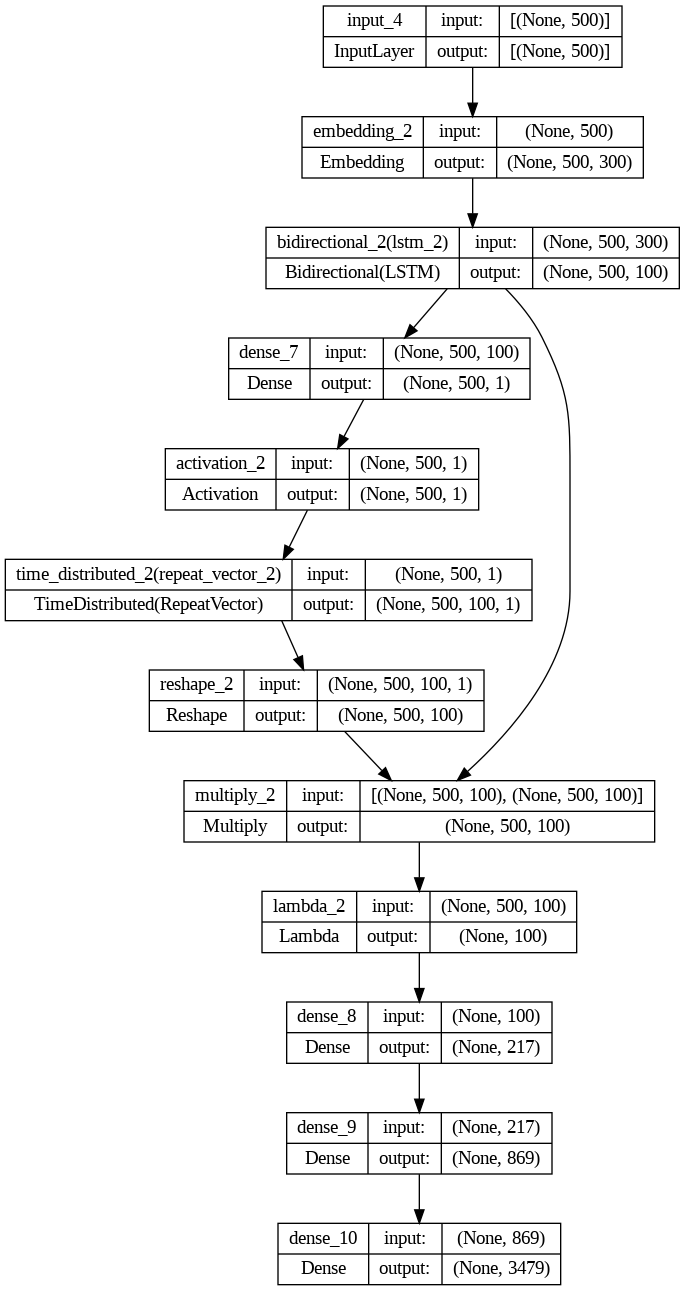

In [ ]:
plot_model(modelGRU, "LM_GRU.png", show_shapes=True)

In [ ]:
adamGRU = tf.keras.optimizers.Adam(learning_rate=5e-3)
modelGRU.compile(loss='categorical_crossentropy', optimizer=adamGRU, metrics=['accuracy'])

### Entrenamiento

In [ ]:
BATCH_SIZE = 64
early_cb = callbacks.EarlyStopping(monitor="accuracy", min_delta=1e-3, patience=10,
                                   start_from_epoch=10)

In [ ]:
historyGRU = modelGRU.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=75,
                    validation_split=0.1, callbacks=[early_cb])

Epoch 1/100
69/69 [==============================] - 487s 7s/step - loss: 5.9236 - accuracy: 0.0749 - val_loss: 6.1976 - val_accuracy: 0.0911
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 5.4956 - accuracy: 0.0986

KeyboardInterrupt: ignored

### Testeo (INCLUYE METRICAS)

In [ ]:
test_loss, test_acc = modelGRU.evaluate(x_test,  y_test)
print(test_acc)

198/198 [==============================] - 4s 21ms/step - loss: 32.8262 - accuracy: 0.0620
0.06200569495558739


# Prediccion

## Greedy Search + ArgMax

In [32]:
def greedy(seed_phrase, token, model, pred_len=25, max_len=500):
  seed_text = token.texts_to_sequences([seed_phrase])[0]
  pred_arr = []

  for _ in range(pred_len):
    aux = np.concatenate((seed_text, pred_arr))
    padded = pad_sequences([aux], maxlen=max_len)
    pred_idx = np.argmax(model.predict(padded, verbose=0)[0])
    pred_arr = np.append(pred_arr, [int(pred_idx)])

  return token.sequences_to_texts([pred_arr])[0]

In [33]:
seed= "Jekyll said"
prediction = greedy(seed, token, model, pred_len=25)
print(seed, prediction)

Jekyll said with a touch of sullenness brightened and i thus the appearance of this drawn in the door that divide of a nausea and distaste of


In [34]:
prediction = ""

while(True):
  seed=input("Seed:")
  if seed != "":
    prediction = greedy(seed, token, model)
  else:
    prediction = greedy(prediction, token, model)
  print(prediction)

KeyboardInterrupt: ignored

## Greedy Search + Temperatura

In [35]:
import random

def greedyTemp(seed_phrase, token, model, temp=1, pred_len=25, max_len=500):
  seed_text = token.texts_to_sequences([seed_phrase])[0]
  pred_arr = []

  for _ in range(pred_len):
    # Concatenamos y paddeamos
    aux = np.concatenate((seed_text, pred_arr))
    padded = pad_sequences([aux], maxlen=max_len)

    # Predecimos considerando temperatura y elegimos de forma semialeatoria
    probs = (model.predict(padded, verbose=0)[0])**(1/temp)
    pred_idx = random.choices(range(len(probs)), weights=probs, k=1)

    # Agregamos el nuevo token a la prediccion
    pred_arr = np.append(pred_arr, [pred_idx])

  return token.sequences_to_texts([pred_arr])[0]

In [37]:
seed= "Jekyll said"
prediction = greedyTemp(seed, token, model, temp=1.25, pred_len=25)
print(seed, prediction)

Jekyll said “o come in his rooms and is no long your loud friend where his it be after but utterson so frown—an god hyde pythias cry


## Stochastic Beam Search

In [38]:
import numpy as np
import random

def stochastic_beam_search(seed_phrase, token, n_beam=3, temp=1.0, pred_len=20):
    seqs = token.texts_to_sequences([seed_phrase])
    probs = [1]

    for paso in range(pred_len):
        new_seqs = []
        new_probs = []

        for i in range(len(seqs)):  # Para cada secuencia
            #paddeamos la sec actual
            padded = pad_sequences([seqs[i]], maxlen=max_len)

            # Generar prediccion y aplicar temp
            pred_probs = (model.predict(padded, verbose=0)[0])**(1/temp)

            # Elegir N opciones en base a sus probs
            pred_idx = random.choices(range(len(pred_probs)), weights=pred_probs, k=n_beam)

            # Apendear token predichos y sus probs calculadas
            for idx in pred_idx:
              new_seqs.append(seqs[i]+[idx])
              new_probs.append(probs[i]*pred_probs[idx])

        # Actualizamos para el sgte paso
        seqs = new_seqs
        probs = new_probs

    likely_idx = probs.index(max(probs))

    return token.sequences_to_texts([seqs[likely_idx]])[0]

In [42]:
seed= "Jekyll said"
prediction = stochastic_beam_search(seed, token, n_beam=3, temp=1, pred_len=5)
print(seed, prediction)

Jekyll said jekyll said with a touch of sullenness


In [44]:
seed= "Jekyll said"
prediction = stochastic_beam_search(seed, token, n_beam=3, temp=2, pred_len=5)
print(seed, prediction)

Jekyll said jekyll said “my like starting a monkey


# Metricas de generación

## Introducción

Métricas de Calidad del Texto:

* **Perplejidad**: La perplejidad mide cuán bien un modelo de lenguaje puede predecir una secuencia de palabras en función de su entrenamiento. Cuanto más bajo sea el valor de perplejidad, mejor es la calidad del texto, ya que indica que el modelo puede predecir con precisión las palabras siguientes en la secuencia. Se utiliza en la evaluación de modelos de lenguaje para evaluar la calidad de la generación de texto

* **BLEU** (Bilingual Evaluation Understudy): es una métrica comúnmente utilizada para evaluar la calidad de la traducción automática y la generación de texto. Compara la similitud de n-gramas (secuencias de palabras) generados por el modelo con las secuencias de palabras de referencia. Cuanto más cercanos sean los n-gramas generados a las referencias, mayor será el puntaje BLEU. Muy utilizado en la evaluación automática de sistemas de traducción automática y generación de resúmenes, entre otros

* **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation): se enfoca en medir la similitud entre palabras y frases del texto generado y las de referencia. Puede incluir métricas como ROUGE-1 (unigramas), ROUGE-2 (bigramas), y ROUGE-L (la longitud de la secuencia común más larga). Se utiliza en la evaluación de resúmenes automáticos y generación de texto. Cuanto más alto sea el puntaje ROUGE, mejor será la calidad del texto generado.

## Perplejidad

In [ ]:
import nltk
from nltk.lm import MLE
from nltk.util import ngrams
import math

# Texto de entrenamiento
training_text = "Este es un ejemplo de texto de entrenamiento para calcular la perplejidad."

# Tokeniza el texto de entrenamiento
tokens = nltk.word_tokenize(training_text)

# Crea un modelo de lenguaje de máxima probabilidad (MLE)
n = 3  # Orden del modelo de lenguaje (trigramas en este caso)
lm = MLE(n)
lm.fit([ngrams(tokens, n)])

# Texto de prueba
test_text = "Este es un ejemplo de texto de prueba para calcular la perplejidad."

# Tokeniza el texto de prueba
test_tokens = nltk.word_tokenize(test_text)

# Calcula la perplejidad del texto de prueba
perplexity = math.pow(2, -lm.perplexity(test_tokens))
print("Perplejidad:", perplexity)

In [ ]:
import tensorflow as tf

def calcPerp(model, seq, max_len=500):
    tokens = token.texts_to_sequences([seq])
    padded = pad_sequences([tokens], maxlen=max_len)

    # Calcular la probabilidad logarítmica de la secuencia
    log_prob = model(padded)
    return tf.exp(-log_prob)

In [ ]:
# Texto de prueba (secuencia de índices de palabras)
texto_de_prueba = [10, 20, 30, 40, 50]  # Reemplaza con tu propia secuencia

# Calcula la perplejidad
perplejidad = calcular_probabilidad(modelo_de_lenguaje, texto_de_prueba)

print("Perplejidad:", perplejidad)

## BLEU

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

blue_calc = lambda ref, pred: sentence_bleu(ref, pred)